In [3]:
import tensorflow as tf
import os
import math
from copy import deepcopy
import numpy as np
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/mac/Documents/FER/DubokoUcenje/Lab1/MNIST_data", one_hot=True)

Extracting /Users/mac/Documents/FER/DubokoUcenje/Lab1/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/mac/Documents/FER/DubokoUcenje/Lab1/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/mac/Documents/FER/DubokoUcenje/Lab1/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/mac/Documents/FER/DubokoUcenje/Lab1/MNIST_data/t10k-labels-idx1-ubyte.gz


In [103]:
def draw_conv_filters(epoch, step, weights, save_dir, name):
    w = weights.copy()
    num_filters = w.shape[3]
    k = w.shape[0]
    #ovo dole treba biti C di je 1 al ono..
    w = w.reshape(num_filters, 1, w.shape[0], w.shape[0])
    w -= w.min()
    w /= 1.*w.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    for i in range(1):
        img = np.zeros([height, width])
        for j in range(16):
            r = int(j / cols) * (k + border)
            c = int(j % cols) * (k + border)
            img[r:r+k,c:c+k] = w[j,i]
    filename = '%s_epoch_%02d_step_%06d_input_%03d.png' % (name, epoch, step, i)
    ski.io.imsave(os.path.join(save_dir, filename), img)

# Moji utils

In [ ]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    (N, H, W, C) = Xs.shape
    grid_size = int(math.ceil(np.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in xrange(grid_size):
        x0, x1 = 0, W
        for x in xrange(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

# Hiperparametri

In [43]:
learning_policy = {1:1e-1, 3:1e-2, 5:1e-3, 7:1e-4}
training_iters = 200000
batch_size = 50
max_epochs = 8
print_every_num_batches = 20
draw_filter = 100
wd = 1e-2
save_dir = './tensorflow_mnist'

n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# Placeholderi i tezine mreze

In [45]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 16])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 32])),
    'wd1': tf.Variable(tf.random_normal([7*7*32, 512])),
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}


x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Izgradnja mreze

In [117]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


def conv_net(x, weights, biases):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [47]:
pred = conv_net(x, weights, biases)

cost = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y) + tf.mul(tf.nn.l2_loss(weights['wc1']), wd)
                      + tf.mul(tf.nn.l2_loss(weights['wc2']), wd)
                      + tf.mul(tf.nn.l2_loss(weights['wd1']), wd)))


learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.initialize_all_variables()

Tensor("Placeholder_28:0", shape=(), dtype=float32)


In [105]:
sess = tf.Session()
sess.run(init)
step = 1
for epoch in range(1, max_epochs):
    if epoch in learning_policy:
        lr = learning_policy[epoch]
        #sess.run([optimizer], feed_dict={learning_rate: 0.1})
    for i in range (mnist.train.num_examples/batch_size):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, loss = sess.run([optimizer,cost], feed_dict={x: batch_x, y: batch_y, learning_rate: 0.001})
        if i % print_every_num_batches ==0:
            print "Epoch %d, step %d/%d, batch loss = %.2f" % (epoch, i*batch_size, mnist.train.num_examples, loss)
        if i % draw_filter == 0:
            draw_conv_filters(epoch, i*batch_size, sess.run(weights['wc1']), save_dir, name = 'conv1')
            
print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images,
                                  y: mnist.test.labels})

Epoch 1, step 0/55000, batch loss = 17629.66


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch 1, step 1000/55000, batch loss = 7837.31
Epoch 1, step 2000/55000, batch loss = 6115.68
Epoch 1, step 3000/55000, batch loss = 5800.43
Epoch 1, step 4000/55000, batch loss = 5423.67
Epoch 1, step 5000/55000, batch loss = 4968.84
Epoch 1, step 6000/55000, batch loss = 5231.74
Epoch 1, step 7000/55000, batch loss = 4631.55
Epoch 1, step 8000/55000, batch loss = 4455.04
Epoch 1, step 9000/55000, batch loss = 4294.23
Epoch 1, step 10000/55000, batch loss = 4917.43
Epoch 1, step 11000/55000, batch loss = 4571.93
Epoch 1, step 12000/55000, batch loss = 4174.62
Epoch 1, step 13000/55000, batch loss = 4661.25
Epoch 1, step 14000/55000, batch loss = 4460.84
Epoch 1, step 15000/55000, batch loss = 4037.09
Epoch 1, step 16000/55000, batch loss = 4001.80
Epoch 1, step 17000/55000, batch loss = 3977.87
Epoch 1, step 18000/55000, batch loss = 4234.36
Epoch 1, step 19000/55000, batch loss = 3966.84
Epoch 1, step 20000/55000, batch loss = 3877.79
Epoch 1, step 21000/55000, batch loss = 4729.13
E

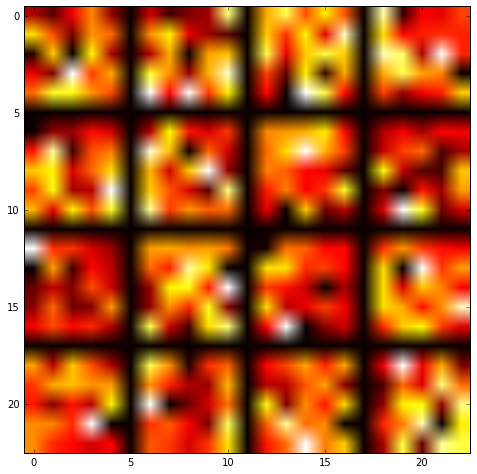

In [106]:
grid = visualize_grid(np.array(sess.run(weights['wc1']).transpose(3, 1, 0, 2)))
plt.figure(figsize=(16,8))
plt.imshow(grid.astype('uint8')[:,:,0],cmap='hot')
plt.show()

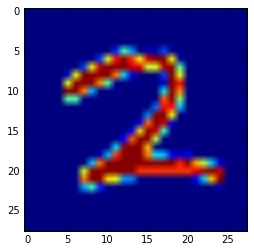

array([[ -6937.10058594,   5955.37841797,  14576.67382812,   -270.87701416,
         -5100.98388672,  -7297.74316406,  -8369.86132812,   4499.02734375,
          2040.25891113,  -4900.33740234]], dtype=float32)

In [116]:
plt.imshow(batch_x[0].reshape(28,28))
plt.show()
sess.run(pred, feed_dict={x: [batch_x[0]]})